## Murcko Scaffolds

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append('..')
sns.set(style='white', context='talk', font_scale=0.9)

In [2]:
# import deepchem
from rdkit import Chem

### Load the data

In [3]:
pkl_file = './df_COCRYS_DUD_DEKOIS_with_Fingerprints_1.pkl'

if  os.path.isfile(pkl_file):
    # this dataset was computed as df_dims_mds in the 2_Comparing...ipynb 
     df_all_mols = pd.read_pickle(pkl_file)

### Murcko Scaffolds

The following function let us to compute Murcko scaffolds, it has been save into `scaffold_splitter.py`.

``` python
from rdkit.Chem.Scaffolds import MurckoScaffold 
from rdkit.Chem import MolToSmiles
from rdkit.Chem import rdDepictor

def scaffold2smiles(mol, generic=True, return_smiles = True):
    ''' Returns a SMILES string representing the Murcko Scaffold of a given molecule'''
    if generic:
        # Makes a Murcko scaffold generic (all atoms -> carbon and all bonds -> single)
        scff = MurckoScaffold.MakeScaffoldGeneric(mol)
        scff = MurckoScaffold.GetScaffoldForMol(scff)
        scff_smiles = MolToSmiles(scff)
    else:
        # Return a smiles scaffold 
        try:
            scff = MurckoScaffold.GetScaffoldForMol(mol)
            scff_smiles =  MolToSmiles(scff)
        except:
            scff_smiles = '' 
            scff = np.nan
    if return_smiles:
        return scff_smiles
    else:
        return scff
```

In [4]:
# Load scaffold2smiles function
from scaffold_splitter import scaffold2smiles

In [5]:
# ************
# Function to compute 2d coords
# ************
to2d = Chem.rdDepictor.Compute2DCoords

#### Compute Murcko Scaffolds

In [6]:
%%time
# Compute or load the dataframe containing the Generic Murcko Scaffolds
file = './df_COCRYS_DUD_DEKOIS_Murcko_Scaffolds_SMILES.pkl'

if os.path.isfile(file):
    df_murcko = pd.read_pickle(file)
else:
    df_murcko = df_all_mols[['library', 'name', 'mol_rdk']].copy()
    # Set index
    df_murcko = df_murcko.set_index(['library', 'name'])
    # Compute Generic Murko Scaffolds
    df_murcko['scff_generic'] = df_murcko.mol_rdk.apply(scaffold2smiles).values
    # Compute Murko Scaffolds
    df_murcko['scff'] = df_murcko.mol_rdk.apply(scaffold2smiles, generic=False).values
    # Save the file
    df_murcko.to_pickle(file)
    
# Add columns
df_murcko['Activity'] = df_all_mols['Activity'].apply(lambda x: 1 if x == 'active' else 0).values

CPU times: user 400 ms, sys: 293 ms, total: 693 ms
Wall time: 691 ms


### Create a dataframe

#### Number of regular scaffolds

In [7]:
# Number of unique molecules
print('Number of different regular Scaffolds:', df_murcko.scff.unique().size)

Number of different regular Scaffolds: 3983


In [8]:
df_murcko['scff'].value_counts().head()

c1ccc(Nc2nnc(-c3ccccc3)c3ccccc23)cc1                52
O=C(NCc1ccccc1)c1cc2ccccc2n1Cc1ccccc1               41
O=C(CSc1nnc(-c2ccccc2)n1-c1ccccc1)Nc1ccccc1         30
C=C(NNC(=O)c1cccc(S(=O)(=O)Nc2ccccc2)c1)c1ccccc1    29
O=C(CSc1nnc(-c2ccccc2)[nH]1)Nc1ccccc1               25
Name: scff, dtype: int64

#### Number of generic scaffolds

In [9]:
print('Number of different generic Scaffolds:', df_murcko.scff_generic.unique().size)

Number of different generic Scaffolds: 2509


In [10]:
df_murcko['scff_generic'].value_counts().head()

C1CCC(CCCCC2CCC(CCC3CCCCC3)CC2)CC1           80
C1CCC(CCCC2CC3CCCCC3C2CC2CCCCC2)CC1          63
C1CCC(CCCCCCC2CCC(C3CCCCC3)C2C2CCCCC2)CC1    60
C1CCC(CCCCC2CCCC(CCC3CCCCC3)C2)CC1           54
C1CCC(CC2CCC(C3CCCCC3)C3CCCCC23)CC1          52
Name: scff_generic, dtype: int64

#### Length of generic scaffold SMILES

In [11]:
# Count the number of molecules inside each scaffolds
scff_counts = df_murcko['scff_generic'].value_counts()
# Get the lenght of the gemeric Scaffold
scff_smiles_len = scff_counts.index.map(len)
# Create a dataframe of unique scaffolds
df_scff_counts = pd.DataFrame({'counts': scff_counts, 'length': scff_smiles_len})
# Sort by length 
df_scff_counts.sort_values('length', inplace=True)
df_scff_counts.head(5)

,counts,length
,1,0
C1CCCC1,3,7
C1CCCCC1,8,8
C1CC2CCCC2C1,2,12
C1CCC2CCCC2C1,3,13


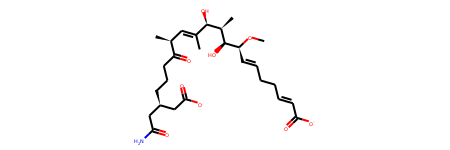

In [12]:
# This molecule doesn't have a Murcko Scaffold (its
df_murcko.loc[('DEKOIS', 'decoy_521'), 'mol_rdk']

In [13]:
# How many scaffolds have more than five molecules?
sum(scff_counts > 5)

166

### Visualize Generic Scaffolds against Normal Scaffolds

In [14]:
# Function to get mol from scaffold smiles
fromSmiles = Chem.MolFromSmiles

#### First Example

In [48]:
# Helper function to visualize examples
def _draw_scaffolds(idx):
    labels = ['Original', 'Regular Scff.', 'Generic Scff.']
    to2d(df_all_mols.loc[idx, 'mol_rdk'])
    original = df_all_mols.loc[idx, 'mol_rdk']
    normal = fromSmiles(df_murcko['scff'].iloc[idx])
    generic = fromSmiles(df_murcko['scff_generic'].iloc[idx])
    mols = [original, normal, generic]
    return Chem.Draw.MolsToGridImage(mols=mols, legends=labels, subImgSize=(200, 200))

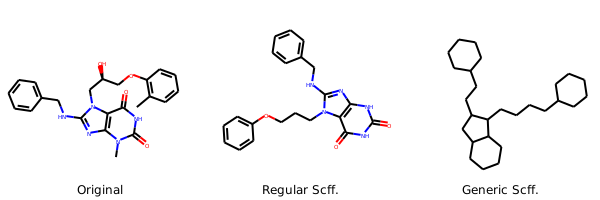

In [50]:
_draw_scaffolds(1759)

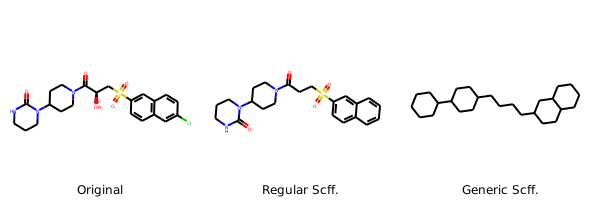

In [52]:
_draw_scaffolds(100)

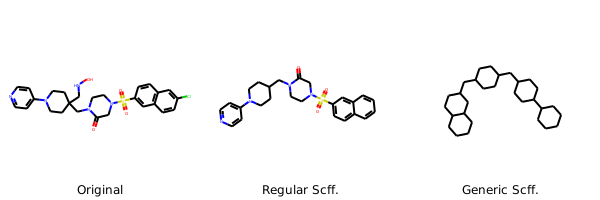

In [54]:
_draw_scaffolds(10)

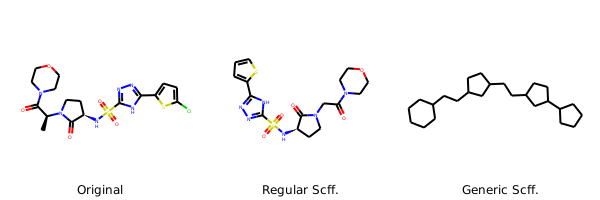

In [55]:
_draw_scaffolds(50)

## Draw most populated generic scaffolds

In [20]:
most_freq_scff = df_murcko['scff_generic'].value_counts().head(28)
most_freq_scff

C1CCC(CCCCC2CCC(CCC3CCCCC3)CC2)CC1              80
C1CCC(CCCC2CC3CCCCC3C2CC2CCCCC2)CC1             63
C1CCC(CCCCCCC2CCC(C3CCCCC3)C2C2CCCCC2)CC1       60
C1CCC(CCCCC2CCCC(CCC3CCCCC3)C2)CC1              54
C1CCC(CC2CCC(C3CCCCC3)C3CCCCC23)CC1             52
C1CCC(CCCCC2CCC(C3CCCCC3)C2)CC1                 52
C1CCC(CCC2CCCC(CCCCC3CCCCC3)C2)CC1              48
C1CCC(CCCCC2CCC(CCC3CCCC3)CC2)CC1               45
C1CCC(CCCCC2CCC(C3CCCCC3)C2C2CCCCC2)CC1         43
C1CCC(CCC(CCCCC2CCCCC2)C2CCCC3CCCCC32)CC1       37
C1CCC(CCCCC2CCC(CCC3CCCCC3)C2)CC1               34
C1CCC(CCC2CC3CCCCC3CC2CC2CCCCC2)CC1             32
C1CCC(CCC2CCCC(CCC3CCCCC3)C2)CC1                32
C1CCC(CCC2CCC(CCC3CCCCC3)CC2)CC1                32
C1CCC(CCCC(CC2CCCCC2)C2CCCCC2)CC1               31
C1CCC(CCCCC2CCC(C3CCCC3)C2C2CCCCC2)CC1          30
C1CCC(CCCCCCC2CC3CCCCC3CC2C2CCCCC2)CC1          29
C1CCC(CCCCCC2CCC(CCC3CCCCC3)CC2)CC1             27
C1CCC(CC2CCC(C3CCCCC3)C3CCCCC32)CC1             26
C1CCC(CCCCC2CCC(CCCCC3CCCCC3)CC

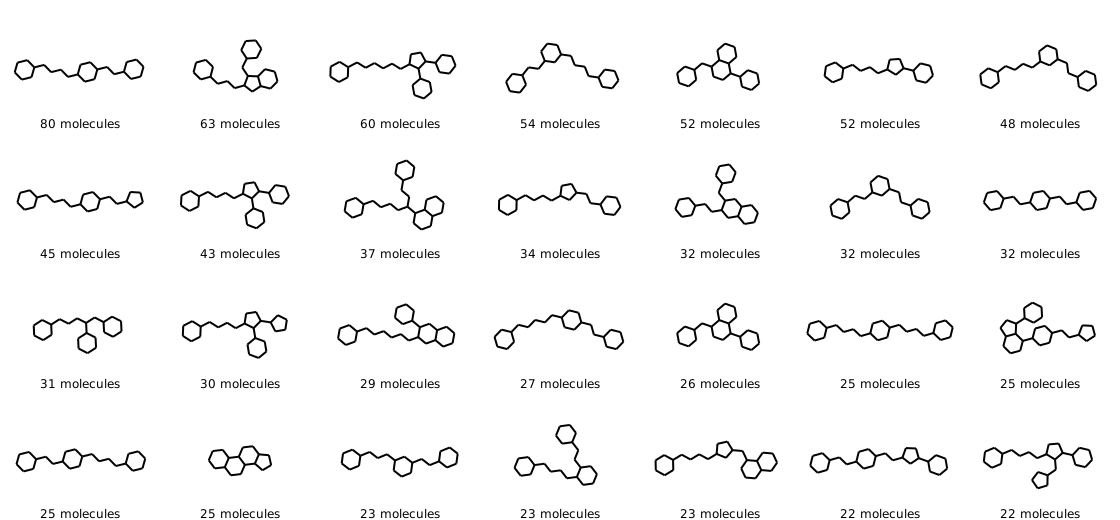

In [21]:
mols = [fromSmiles(mol) for mol in most_freq_scff.index.values]
num_mols_per_scff = [f'{n_mols} molecules' for n_mols in most_freq_scff]
Chem.Draw.MolsToGridImage(mols=mols, molsPerRow=7, legends=num_mols_per_scff, subImgSize=(160,130))

### Scaffolds Dsitribution between Molecular Libraries

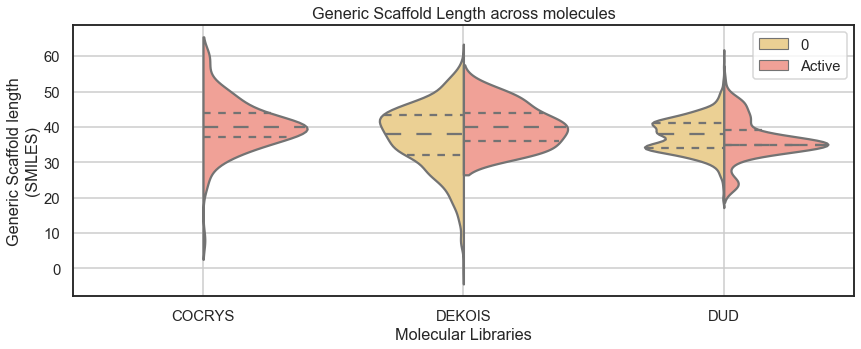

In [22]:
import seaborn as sns
sns.set(context='talk', style='white', font_scale=0.9)

df_murcko['len_scff_gen'] = df_murcko.scff_generic.apply(len)
data = pd.melt(df_murcko.reset_index(), id_vars=['library', 'Activity'], 
               value_vars='len_scff_gen',
              value_name='len_scff_gen')

# Violin Plots
f, ax = plt.subplots(figsize=(14,5))
ax = sns.violinplot(x='library', y='len_scff_gen', hue='Activity', data=data, split=True,
                   palette=['#FAD585', '#FF9588'], inner='quartile', scale='area', ax = ax)
plt.grid()
plt.legend().get_texts()[1].set_text('Active')
ax.set(title='Generic Scaffold Length across molecules', xlabel='Molecular Libraries',
      ylabel='Generic Scaffold length\n(SMILES)')
plt.show()

In [23]:
print('Merged Libraries')
display(df_murcko.groupby('Activity').describe())

print('\nCOCRYS Library')
display(df_murcko.loc['COCRYS'].groupby('Activity').describe())

print('\nDEKOIS Library')
display(df_murcko.loc['DEKOIS'].groupby('Activity').describe())

print('\nDUD Library')
display(df_murcko.loc['DUD'].groupby('Activity').describe())

Merged Libraries


len_scff_gen                                                  
                count       mean       std  min   25%   50%   75%   max
Activity                                                               
0              5539.0  37.538003  6.010746  0.0  34.0  38.0  41.0  60.0
1               300.0  38.476667  6.661635  8.0  35.0  37.0  42.0  60.0


COCRYS Library


len_scff_gen                                              
                count   mean       std  min   25%   50%   75%   max
Activity                                                           
1               125.0  40.28  7.161276  8.0  37.0  40.0  44.0  60.0


DEKOIS Library


len_scff_gen                                                    
                count       mean       std   min   25%   50%    75%   max
Activity                                                                 
0              1180.0  37.233898  9.062662   0.0  32.0  38.0  43.25  59.0
1                39.0  40.128205  5.768241  32.0  36.0  40.0  44.00  52.0


DUD Library


len_scff_gen                                                   
                count       mean       std   min   25%   50%   75%   max
Activity                                                                
0              4359.0  37.620326  4.864163  19.0  34.0  38.0  41.0  60.0
1               136.0  36.345588  5.782962  23.0  35.0  35.0  39.0  53.0

***
# Use DeepChem to compute the Scaffold splitting

Sources:
-  https://deepchem.io/docs/_modules/deepchem/splits/splitters.html
-  https://deepchem.io/deepchem.splits.html
- https://github.com/pandegroup/deepchem_enf/blob/master/deepchem/utils/featurize.py

### Split function used by deepchem

```python
def split(self,
            dataset,
            frac_train=.8,
            frac_valid=.1,
            frac_test=.1,
            log_every_n=1000): # Usa la función log para guardar
    """
        Splits internal compounds into train/validation/test by scaffold.
        """
    #** 
    np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.)
    
    #** Crea un diccionario vacío
    scaffolds = {}
    log("About to generate scaffolds", self.verbose)
    data_len = len(dataset)
    
    #** El objeto de la clase Dataset tiene como atributo ids al smiles de la molécula
    for ind, smiles in enumerate(dataset.ids): 
      if ind % log_every_n == 0:
        log("Generating scaffold %d/%d" % (ind, data_len), self.verbose)
        
      # Genera los scaffolds de Murcko
      scaffold = generate_scaffold(smiles) # La función implementa MurckoScaffoldSmiles
        # Con lo cual, no da opción de Scaffolds genéricos, y sólo funciona desde SMILES
        
      #********************
      # La clave para ir llenando los bins está aquí
      #********************
      if scaffold not in scaffolds:
        scaffolds[scaffold] = [ind] # Crea una nueva entrada si el scaffold no ha sido 'visto'
        # El key es el scaffold y el value es una lista con el índice de la primera ocurrencia
      else:
        scaffolds[scaffold].append(ind) # Si el scaffold ya existe, añade el índice de la ocurrencia
        
    # Ordena los índices de las moléculas que pertenecen a cada scaffold
    # Sort from largest to smallest scaffold sets
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
    
    # Crea una lista con las listas de los índices de cada scaffold
    # Ordenando por longitud del número de índices en el set, y por el valor del primer índice
    # Cada scaffold_set es una lista de índices que pertenecen a un scaffold en particular
    scaffold_sets = [
        scaffold_set
        for (scaffold, scaffold_set) in sorted(
            scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
    ]
    # La longitud del Train set se establece según la longitud del dataset
    train_cutoff = frac_train * len(dataset)
    valid_cutoff = (frac_train + frac_valid) * len(dataset)
    # Se crean las listas vacias de los tres sets
    # Cuando no se requiere el set de validación, se omite estableciendo el frac_valid = 0
    train_inds, valid_inds, test_inds = [], [], []
    log("About to sort in scaffold sets", self.verbose)
    
    # Por cada scaffold_set:
    for scaffold_set in scaffold_sets:
      # Si lo que hay ya en train_inds más el scaffold_set es mayor al cutoff para el train set 
      if len(train_inds) + len(scaffold_set) > train_cutoff:
        # Lo mismo para el valid set
        if len(train_inds) + len(valid_inds) + len(scaffold_set) > valid_cutoff:
          test_inds += scaffold_set
        else:
          valid_inds += scaffold_set
      else:
        train_inds += scaffold_set
        
    return train_inds, valid_inds, test_inds
```

### Compute ScaffoldSplitter
1. ScaffoldSplitter requires a `dataset` object from class Dataset.
2. Murcko Scaffolds are computed only from SMILES format ([Source code](https://github.com/pandegroup/deepchem_enf/blob/master/deepchem/utils/featurize.py))

#### Create the dataset object

In [56]:
from deepchem.data import NumpyDataset 
from rdkit import Chem

#### Helper Function to get a Dataset object required to use `ScaffoldSplitter` class from deepchem.

In [25]:
def _get_depchem_dataset(df, smiles_col='scff_generic'):
    '''This is a very particular funtion to return a 'Dataset' object from the 
    df_murcko dataframe, created  above.'''
    # Molecules are required in SMILES format
    df_dataset = df[['scff_generic', 'scff']].copy() # X dataset
    df_dataset['y'] = df.Activity # target value
    df_dataset['smiles'] = [Chem.MolToSmiles(mol) for mol in df.mol_rdk] # ids values

    # Print some properties
    print('Number of molecules:', df_dataset.shape[0])
    print('Number of actives:', df_dataset.y.sum())

    # Create the deepchem dataset
    dataset_g = NumpyDataset(X = df_dataset.drop('y', axis=1), # Features set
                             y = df_dataset['y'], # Target values
                             ids=df_dataset[smiles_col]) # SMILES should be column ids
    return dataset_g

### Scaffold Splitting over the merged dataset (all libraries)

In [26]:
from deepchem.splits.splitters import ScaffoldSplitter

##### Scaffold Splitting over Merged dataset (COCRYS, DEKOIS and DUD)

In [27]:
#****************
# Merged Dataset
#****************
print('MERGED dataset (all libraries)\n' + '*'*30)
merged_dataset = _get_depchem_dataset(df_murcko)
x_g = ScaffoldSplitter().train_test_split(merged_dataset)
# Training set
print('+'*30)
X_train, y_train = x_g[0].X, x_g[0]._y
print('-Training set shape', X_train.shape)
print('-Number of actives in y_train:', y_train.sum())

# Test set 
X_test, y_test = x_g[1].X, x_g[1]._y
print('-Test set shape', X_test.shape)
print('-Number of actives in y_test:', y_test.sum())

MERGED dataset (all libraries)
******************************
Number of molecules: 5839
Number of actives: 300
++++++++++++++++++++++++++++++
-Training set shape (4671, 3)
-Number of actives in y_train: 232
-Test set shape (1168, 3)
-Number of actives in y_test: 68


##### Scaffold Splitting over  DEKOIS
As we will see, the problem with this splitting is that it not guaranties a stratified (proportional) distribution of actives and inactives between Train and Test sets.

In [28]:
#****************
# DEKOIS Dataset
#****************
library = 'DEKOIS'
print(library + ' dataset\n' + '*'*30)
merged_dataset = _get_depchem_dataset(df_murcko.loc[library])
x_g = ScaffoldSplitter().train_test_split(merged_dataset)
# Training set
print('+'*30)
X_train, y_train = x_g[0].X, x_g[0]._y
print('-Training set shape', X_train.shape)
print('-Number of actives in y_train:', y_train.sum())

# Test set 
X_test, y_test = x_g[1].X, x_g[1]._y
print('-Test set shape', X_test.shape)
print('-Number of actives in y_test:', y_test.sum())


DEKOIS dataset
******************************
Number of molecules: 1219
Number of actives: 39
++++++++++++++++++++++++++++++
-Training set shape (975, 3)
-Number of actives in y_train: 8
-Test set shape (244, 3)
-Number of actives in y_test: 31


##### Scaffold Splitting over  DUD

In [29]:
#****************
# DUD Dataset
#****************
library = 'DUD'
print(library + ' dataset\n' + '*'*30)
merged_dataset = _get_depchem_dataset(df_murcko.loc[library])
x_g = ScaffoldSplitter().train_test_split(merged_dataset)
# Training set
print('+'*30)
X_train, y_train = x_g[0].X, x_g[0]._y
print('-Training set shape', X_train.shape)
print('-Number of actives in y_train:', y_train.sum())

# Test set 
X_test, y_test = x_g[1].X, x_g[1]._y
print('-Test set shape', X_test.shape)
print('-Number of actives in y_test:', y_test.sum())

DUD dataset
******************************
Number of molecules: 4495
Number of actives: 136
++++++++++++++++++++++++++++++
-Training set shape (3596, 3)
-Number of actives in y_train: 109
-Test set shape (899, 3)
-Number of actives in y_test: 27


## Defining our own stratified Scaffold Splitter

```python
def scaffold_splitter(scaffold_series, test_size=0.2, stratify=None):
    '''
    Performs a Train Test splitting using Murcko Scaffolds.
    
    Parameters:
    -----------
        scaffold_series: pandas Series.
            Series object with precomputed Murcko Scaffolds (SMILES format).
        train_size, test_size, valid_size: float.
            Train, Validation and Test fraction size for each subset.
    Retunrs:
    --------
        train_inds, valid_inds, test_inds: array-like.
            Arrays containing the molecule indices of the corresponding train, test subset.
    '''
    
    assert test_size < 0.8, 'test_size must be a float number less than 0.8'
    
    train_size = 1 - test_size
    scaffolds = {}
    train_inds, valid_inds, test_inds = [], [], []
    
    if isinstance(stratify, pd.Series): 
        # Use stratify (y) to get active indices
        actives = (stratify == 1)
        scaffold_series_actives = scaffold_series[actives] # Keep Actives
        scaffold_series = scaffold_series[~actives] # Keep Inactives
        # Perform Train/Test Splitting only for actives
        act_train_inds, act_valid_inds, act_test_inds = scaffold_splitter(
                                              scaffold_series_actives, 
                                              test_size=test_size, stratify=None)
        # Start filling train_inds, valid_inds, test_inds with active indices
        train_inds, valid_inds, test_inds = act_train_inds, act_valid_inds, act_test_inds
    
    data_len = len(scaffold_series)
    
    for ind, scff in scaffold_series.items():
        if scff not in scaffolds:
                scaffolds[scff] = [ind]
        else:
            scaffolds[scff].append(ind)
    # Sort from largest t smallest scaffold sets
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
    # Scaffold sets
    scaffold_sets = [
        scff_set
        for (scff, scff_set) in sorted(
            scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
    ]
    
    # create Train and Test sets
    train_cutoff = int(train_size * data_len)
    
    # Full Train-Test sets
    for scff_set in scaffold_sets:
        if len(train_inds) + len(scff_set) > train_cutoff:
            test_inds += scff_set
        else:
            train_inds += scff_set
    return train_inds, valid_inds, test_inds
 
```

In [57]:
# Load the function
#*************************************************
# Functions to compute stratify scaffold splitting
#*************************************************
from scaffold_splitter import train_test_scaffold_split, scaffold_splitter

## Comparing Deepchem's *train_test_split* function against ours
### Deepchem `ScaffoldSplitter().split()`

In [31]:
#****************************
# Deepchem Scaffold splitting 
#****************************
library = 'DEKOIS'
df = df_murcko.loc[library]
print(library + ' dataset\n' + '*'*30)
merged_dataset = _get_depchem_dataset(df, 'smiles')
train_scff, _, test_scff = ScaffoldSplitter().split(merged_dataset, frac_test=0.2, frac_train=0.8, frac_valid=0)
y_true = df['Activity']
y_train = y_true.iloc[train_scff]
y_test = y_true.iloc[test_scff]

print('Train size:', y_train.size)
print('Test size:', y_test.size)
print('Number of actives in y_train:', y_train.sum())
print('Number of actives in y_test:', y_test.sum())

test_scff_deepchem = df.iloc[test_scff]
test_scff_deepchem.query('Activity == 1').sort_values('len_scff_gen').head(6)

DEKOIS dataset
******************************
Number of molecules: 1219
Number of actives: 39
Train size: 975
Test size: 244
Number of actives in y_train: 2
Number of actives in y_test: 37


,mol_rdk,scff_generic,scff,Activity,len_scff_gen
name,,,,,
ligand_20,<rdkit.Chem.rdchem.Mol object at 0x7fd1148c8eb0>,C1CCC(CCCCC2CCC(C3CCCCC3)CC2)CC1,c1ccc(NCCOc2ccc(-c3ccccc3)cc2)cc1,1,32
ligand_18,<rdkit.Chem.rdchem.Mol object at 0x7fd1148c8e30>,C1CCC(CC2C3CCCCC3CC2C2CCCCC2)CC1,c1ccc(Cc2c(-c3ccccc3)[nH]c3ccccc23)cc1,1,32
ligand_21,<rdkit.Chem.rdchem.Mol object at 0x7fd1148c8ef0>,C1CCC(CCCCC2CCC(CC3CCCC3)CC2)CC1,O=C(COc1ccccc1)Nc1ccc(C(=O)N2CCCC2)cc1,1,32
ligand_10,<rdkit.Chem.rdchem.Mol object at 0x7fd1148c8c70>,C1CCC(CC2CCC(CCCCC3CCCCC3)CC2)CC1,C(=C/c1ccccc1)\CNc1ccc(OC2CCNCC2)cc1,1,33
ligand_16,<rdkit.Chem.rdchem.Mol object at 0x7fd1148c8db0>,C1CCC(CCCCCC2CCC(C3CCCCC3)CC2)CC1,O=C(NCCCc1ccccc1)c1ccc(-c2ccccc2)cc1,1,33
ligand_19,<rdkit.Chem.rdchem.Mol object at 0x7fd1148c8e70>,C1CCC(C2CCCC(C3CC4CCCCC4C3)C2)CC1,c1ccc(-c2cccc(-c3nc4ccccc4[nH]3)c2)cc1,1,33


### Our Splitting function `scaffold_splitter()`

In [32]:
library = 'DEKOIS'
df = df_murcko.loc[library, ['Activity', 'len_scff_gen', 'scff_generic', 'scff']].copy().reset_index()
train_scff, _, test_scff = scaffold_splitter(df['scff'],  test_size=0.2)
y_true = df['Activity']
y_train = y_true.iloc[train_scff]
y_test = y_true.iloc[test_scff]

print('Train size:', y_train.size)
print('Test size:', y_test.size)
print('Number of actives in y_train:', y_train.sum())
print('Number of actives in y_test:', y_test.sum())

test_scff_ = df.iloc[test_scff]
test_scff_.query('Activity == 1').set_index('name').sort_values('len_scff_gen').head(6)

Train size: 975
Test size: 244
Number of actives in y_train: 2
Number of actives in y_test: 37


,Activity,len_scff_gen,scff_generic,scff
name,,,,
ligand_20,1,32,C1CCC(CCCCC2CCC(C3CCCCC3)CC2)CC1,c1ccc(NCCOc2ccc(-c3ccccc3)cc2)cc1
ligand_18,1,32,C1CCC(CC2C3CCCCC3CC2C2CCCCC2)CC1,c1ccc(Cc2c(-c3ccccc3)[nH]c3ccccc23)cc1
ligand_21,1,32,C1CCC(CCCCC2CCC(CC3CCCC3)CC2)CC1,O=C(COc1ccccc1)Nc1ccc(C(=O)N2CCCC2)cc1
ligand_10,1,33,C1CCC(CC2CCC(CCCCC3CCCCC3)CC2)CC1,C(=C/c1ccccc1)\CNc1ccc(OC2CCNCC2)cc1
ligand_16,1,33,C1CCC(CCCCCC2CCC(C3CCCCC3)CC2)CC1,O=C(NCCCc1ccccc1)c1ccc(-c2ccccc2)cc1
ligand_19,1,33,C1CCC(C2CCCC(C3CC4CCCCC4C3)C2)CC1,c1ccc(-c2cccc(-c3nc4ccccc4[nH]3)c2)cc1


### Our Splitting function `scaffold_splitter()` with a proportional number of actives between Train and Test sets

In [33]:
library = 'DEKOIS'
df = df_murcko.loc[library, ['Activity', 'len_scff_gen', 'scff_generic', 'scff']].copy().reset_index()
y_true = df['Activity']
train_scff, _, test_scff = scaffold_splitter(df['scff'], stratify=y_true,  test_size=0.2)
y_train = y_true.iloc[train_scff]
y_test = y_true.iloc[test_scff]

print('Train size:', y_train.size)
print('Test size:', y_test.size)
print('Number of actives in y_train:', y_train.sum())
print('Number of actives in y_test:', y_test.sum())

test_scff_ = df.iloc[test_scff]
test_scff_.query('Activity == 1').set_index('name').sort_values('len_scff_gen').head(6)

Train size: 944
Test size: 275
Number of actives in y_train: 31
Number of actives in y_test: 8


,Activity,len_scff_gen,scff_generic,scff
name,,,,
ligand_4,1,37,C1CCC(C2CCC(CCC3CCCC3C3CCCCC3)CC2)CC1,O=C(Nc1ccc(-c2ccccc2)cc1)c1ccnn1-c1ccccc1
ligand_1,1,37,C1CCC(C2CCC(CCC3CCCC3C3CCCCC3)CC2)CC1,O=C(Nc1ncc(-c2ccccc2)cn1)c1ccnn1-c1ccccc1
ligand_7,1,40,C(CCCC(CCCC1CCCCC1)CCC1CCCCC1)CCC1CCCCC1,O=C(CNC(=O)[C@@H](CCc1cccc[nH+]1)NS(=O)(=O)Cc1...
ligand_5,1,40,C1CCC(C2CCC3CCC(C4CCC(C5CC5)CC4)CC32)CC1,O=C1c2c(cnn2-c2ccccc2)CCN1c1ccc(C2CC2)cc1
ligand_2,1,40,C1CCC(CCC2CCCCC2CCC2CCC(CCC3CCCC3)C2)CC1,O=C(Nc1ccccc1C(=O)Nc1ccccn1)c1cc(CNC2=[NH+]CCC...
ligand_6,1,41,C1CCC(CC2CCC3CCC(CC4CCC5CCCCC5C4)C3C2)CC1,c1ccc2cc(Cn3cnc4ccc(OC5CCNCC5)cc43)ccc2c1
